## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import RidgeClassifier

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
[column for column in data.columns if data.dtypes[column] == np.object]

['sex', 'cabin', 'embarked', 'title']

In [11]:
vars_num = [column for column in data.columns if data.dtypes[column] != np.object]

vars_cat = [column for column in data.columns if data.dtypes[column] == np.object]

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


### Find missing values in variables

In [12]:
def NA_info(data,columns):
    """
        Print information about missing values in columns:
        - quantity of missing values
        - percent of missing values 
        Parametrs:
        - data - dataset
        - columns - list of columns
    """
    data_NA_statistic = pd.DataFrame(data[columns].isna().sum(axis=0).sort_values(ascending=False),columns=['count'])
    data_NA_statistic['NA_percent'] = data_NA_statistic['count'] / len(data) * 100
    return data_NA_statistic

In [13]:
# first in numerical variables
NA_info(data,vars_num)

,count,NA_percent
age,263,20.091673
fare,1,0.076394
parch,0,0.000000
sibsp,0,0.000000
survived,0,0.000000
pclass,0,0.000000


In [14]:
# now in categorical variables
NA_info(data,vars_cat)

,count,NA_percent
cabin,1014,77.463713
embarked,2,0.152788
title,0,0.000000
sex,0,0.000000


### Determine cardinality of categorical variables

In [15]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

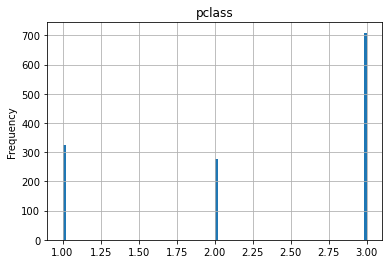

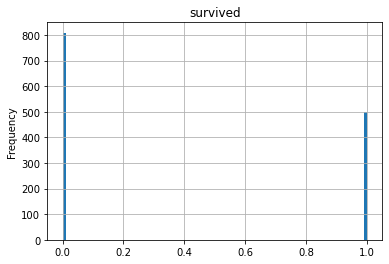

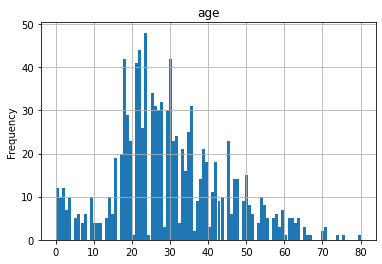

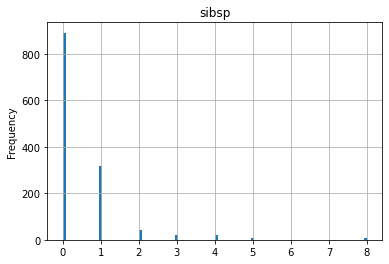

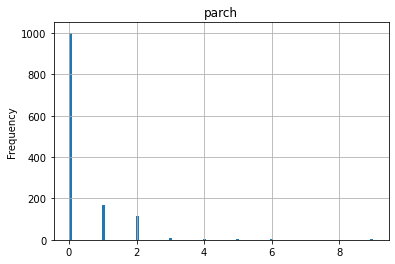

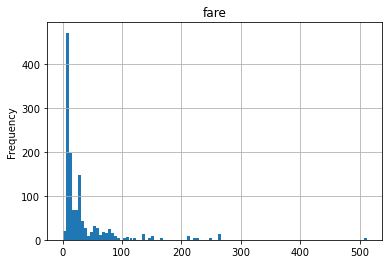

In [16]:
def analyse_continuous(df, var):
    df[var].plot.hist(grid=True, bins=100, rwidth=0.98);
    plt.title(var)
    plt.show()

for var in vars_num:
    analyse_continuous(data, var)

After that point, We'll move some variables from numeric to categorical, because they are discrete variables. Also we'll delete target features from vars_num

In [17]:
list_for_move = ['pclass','sibsp','parch']
vars_cat = vars_cat + list_for_move
vars_num = [x for x in vars_num if x not in list_for_move and x != 'survived']

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [19]:
X_train['cabin'] = X_train['cabin'].replace('\d+', '', regex=True)
X_test['cabin'] = X_test['cabin'].replace('\d+', '', regex=True)

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [20]:
vars_with_na = [var for var in vars_num if X_train[var].isnull().sum()>0]

for var in vars_with_na:

    # calculate the median using the train set
    median_val = X_train[var].median()

    # add binary missing indicator (in train and test)
    X_train[var+'_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the median
    # (in train and test)
    X_train[var] = X_train[var].fillna(median_val)
    X_test[var] = X_test[var].fillna(median_val)

# check that we have no more missing values
NA_info(X_train,vars_num)

,count,NA_percent
fare,0,0.0
age,0,0.0


### Replace Missing data in categorical variables with the string **Missing**

In [21]:
vars_with_na = [var for var in vars_cat if X_train[var].isnull().sum()>0]

for var in vars_with_na:
    X_train[var] = X_train[var].fillna('Missing')
    X_test[var] = X_test[var].fillna('Missing')
NA_info(X_train,vars_cat)

,count,NA_percent
parch,0,0.0
sibsp,0,0.0
pclass,0,0.0
title,0,0.0
embarked,0,0.0
cabin,0,0.0
sex,0,0.0


### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [22]:
def find_frequent_labels(df, var, rare_perc):
    '''
     Function finds the labels that are shared by more than
     a certain % of the rows in the dataset
    '''
    tmp = df[var].value_counts() / df.shape[0]
    return tmp[tmp > rare_perc].index

for var in vars_cat:
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [23]:
X_train = pd.get_dummies(X_train, columns=vars_cat)
X_test = pd.get_dummies(X_test, columns=vars_cat)
X_train,X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

In [24]:
X_train.head()

,age,age_na,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_Missing,cabin_Rare,embarked_C,embarked_Q,embarked_Rare,embarked_S,fare,fare_na,parch_0,parch_1,parch_2,parch_Rare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,sibsp_0,sibsp_1,sibsp_2,sibsp_3,sibsp_4,sibsp_Rare,title_Master,title_Miss,title_Mr,title_Mrs,title_Other
1118,25.0,0,0,0,0,0,0,0,1,0,0,0,0,1,7.9250,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0
44,41.0,0,0,0,0,0,1,0,0,0,1,0,0,0,134.5000,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0
1072,28.0,1,0,0,0,0,0,0,1,0,0,1,0,0,7.7333,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0
1130,18.0,0,0,0,0,0,0,0,1,0,0,0,0,1,7.7750,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0
574,29.0,0,0,0,0,0,0,0,1,0,0,0,0,1,21.0000,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0


### Scale the variables

- Use the standard scaler from Scikit-learn

In [25]:
scaler = StandardScaler()
scaler.fit(X_train[vars_num])
X_train[vars_num] = scaler.transform(X_train[vars_num])
X_test[vars_num] = scaler.transform(X_test[vars_num])

In [26]:
X_train.head()

,age,age_na,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_Missing,cabin_Rare,embarked_C,embarked_Q,embarked_Rare,embarked_S,fare,fare_na,parch_0,parch_1,parch_2,parch_Rare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,sibsp_0,sibsp_1,sibsp_2,sibsp_3,sibsp_4,sibsp_Rare,title_Master,title_Miss,title_Mr,title_Mrs,title_Other
1118,-0.370162,0,0,0,0,0,0,0,1,0,0,0,0,1,-0.504782,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0
44,0.904029,0,0,0,0,0,1,0,0,0,1,0,0,0,1.971555,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0
1072,-0.131251,1,0,0,0,0,0,0,1,0,0,1,0,0,-0.508533,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0
1130,-0.927621,0,0,0,0,0,0,0,1,0,0,0,0,1,-0.507717,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0
574,-0.051614,0,0,0,0,0,0,0,1,0,0,0,0,1,-0.248980,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [27]:
clr = RidgeClassifier(alpha = 0.0005, random_state=0)
clr.fit(X_train,y_train)
# we persist the model for future use
joblib.dump(clr, 'ridge_classifier.pkl')

['ridge_classifier.pkl']

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [28]:
# make predictions for train set
pred = clr.predict(X_train)
# print metrics accuracy_score, roc_auc_score
print('train  accuracy: {0:.4f}'.format(accuracy_score(pred,y_train)))
print('train  roc_auc: {0:.4f}'.format(roc_auc_score(pred,y_train)))

# make predictions for test set
pred_test = clr.predict(X_test)
# print metrics accuracy_score, roc_auc_score
print('test  accuracy: {0:.4f}'.format(accuracy_score(pred_test,y_test)))
print('test  roc_auc: {0:.4f}'.format(roc_auc_score(pred_test,y_test)))


train  accuracy: 0.8157
train  roc_auc: 0.8052
test  accuracy: 0.8168
test  roc_auc: 0.8131


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**